In [ ]:
# google colab で実行する場合は以下のコメントアウトを外す
# ! wget https://github.com/KHiraGit/sudspg_ds/raw/main/ds09_icecream.xlsx
# ! pip install statsmodels==0.13.1
# ! pip install pmdarima

In [44]:
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm

In [45]:
# アイスクリームの売上データ 
# https://www.icecream.or.jp/iceworld/data/expenditures.html
icecream_df = pd.read_excel('ds09_icecream.xlsx', index_col=0)

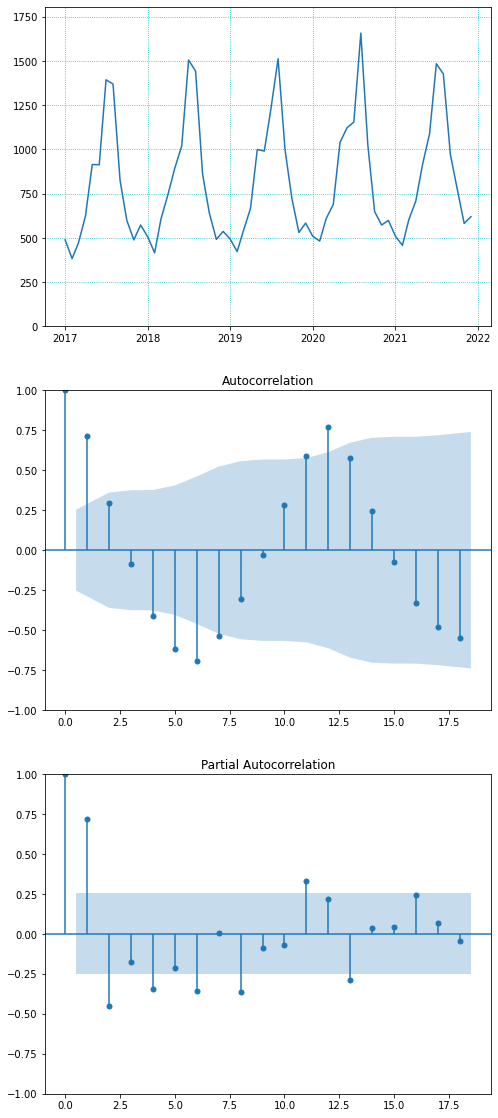

In [52]:
# アイスクリーム売上のグラフを表示
fig = plt.figure(figsize=(8, 20))  
ax = fig.add_subplot(311)
ax.plot(icecream_df)
y_min, y_max = ax.get_ylim()
ax.set_ylim(0, y_max * 1.05)
ax.grid(axis='both',linestyle='dotted', color='c')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 

# 自己相関係数と偏自己相関係数のグラフを表示
ax1 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_acf(icecream_df, ax=ax1)
ax2 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_pacf(icecream_df, ax=ax2, method='ywm')

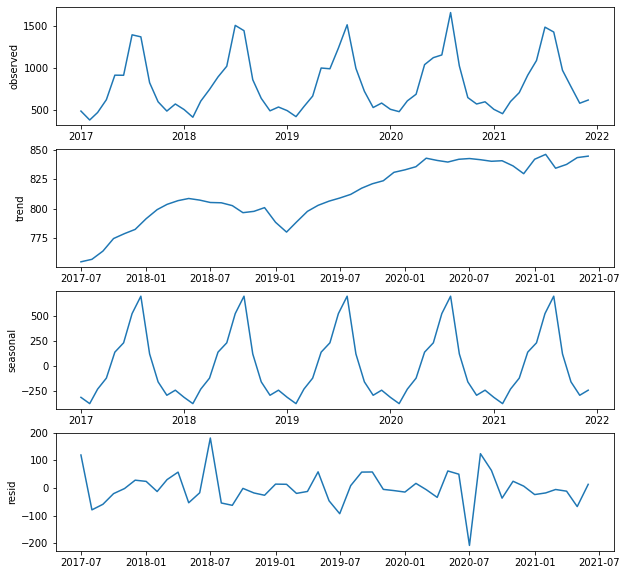

In [47]:
# 時系列データをトレンド、規則的変動成分、不規則変動成分に分解
res = sm.tsa.seasonal_decompose(icecream_df, period=12)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(411)
ax1.set_ylabel('observed')
ax1.plot(res.observed)
ax2 = fig.add_subplot(412)
ax2.set_ylabel('trend')
ax2.plot(res.trend)
ax3 = fig.add_subplot(413)
ax3.set_ylabel('seasonal')
ax3.plot(res.seasonal)
ax4 = fig.add_subplot(414)
ax4.set_ylabel('resid')
ax4.plot(res.resid)


In [56]:
# モデル構築と検証のためのデータを準備
train = icecream_df[0:48]  # 学習用データ 2020年まで
test = icecream_df[48:]  # 検証用データ 2021年分

In [59]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train, seasonal=True, trace=True, m=12, stepwise=True)                         
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=421.690, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=425.182, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=425.193, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=424.302, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=423.193, Time=0.08 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=423.209, Time=0.05 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=425.098, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=423.643, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=423.609, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=423.960, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.429 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -208.845
Date:                  Thu, 09 Jun 2022   AIC                            421.690
Time:                          16:40:07   BIC                            424.857
Sample:                               0   HQIC                           422.795
                                   - 48                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     29.5833     16.358      1.808      0.071      -2.478      61.645
sigma2      6403.6319   1135.296      5.640      0.000    4178.492    8628.771
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                27.21
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -1.34
Prob(H) (two-sided):                  0.77   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

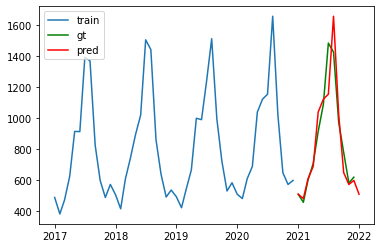

In [60]:
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
SARIMA = sm.tsa.SARIMAX(train.earning, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12)).fit()
pred = SARIMA.predict('2021-01-01', '2022-01-01')
# 実データと予測結果の図示
plt.plot(train.earning, label="train")
plt.plot(test.earning, "g", label="gt")
plt.plot(pred, "r", label="pred")
plt.legend()